# 谱聚类

In [1]:
import warnings
import numpy as np
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score,recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_circles,make_moons
from sklearn.metrics.pairwise import rbf_kernel
mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

评分： 0.892


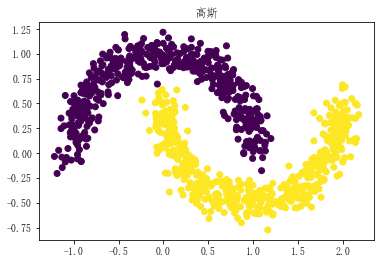

评分： 0.502


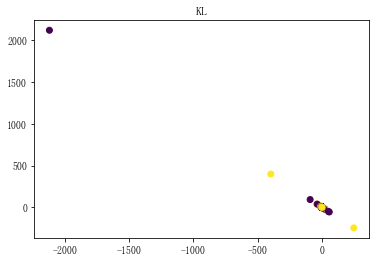

In [4]:
class SpectralCluster:
    def __init__(self, n_clusters=None, gamma=None, k=10, sigma=None, affinity="rbf", num=1):
        """

        """
        self.n_clusters = n_clusters
        self.W = None
        self.N = None  # 样本数量/结点数量
        self.D = None  # 度矩阵
        self.L = None  # 拉普拉斯矩阵
        self.sigma = sigma  # 高斯函数的sigma
        self.affinity = affinity  # 创建相似矩阵的方法
        self.k = k  # knn
        self.num = num
        self.X = None
        self.y = None

        self.score = None

        if self.n_clusters == None:
            self.n_clusters = 2

        if self.sigma == None:
            self.sigma = 1.0

    def init_params(self, X, y):
        self.N = X.shape[0]
        self.W = self.similaryMatrix(X).astype(float)
        self.D = self.diagMatrix()
        self.L = self.laplacianMatrix().astype(float)

    def diagMatrix(self, ):
        """
        对角矩阵
        """
        diag = np.sum(self.W, axis=1)
        return diag

    # 离散随机变量的KL散度和JS散度的计算方法
    def KL(self, p, q):
        # p,q为两个list，里面存着对应的取值的概率，整个list相加为1
        p /= np.sum(p)
        q /= np.sum(q)
        if 0 in q:
            return 0
        return np.sum([_p * np.log(np.abs(_p / _q)) for _p, _q in zip(p, q) if _p != 0])

    def JS(self, p, q):
        M = [0.5 * (_p + _q) for (_p, _q) in zip(p, q)]
        return 0.5 * (self.KL(p, M) + self.KL(q, M))

    def distance(self, xi, yi):
        distance = np.sqrt(np.power(xi - yi, 2).sum())
        return distance

    def get_distance_matrix(self, data):
        """
        获取距离矩阵
        """
        dist_matrix = np.zeros((self.N, self.N))
        for i in range(self.N):
            for j in range(i + 1, self.N):
                dist_matrix[i][j] = dist_matrix[j][i] = self.distance(data[i], data[j])
        return dist_matrix

    def similaryMatrix(self, data):
        """
        相似矩阵/邻接矩阵/权值矩阵
        """
        S = np.zeros((self.N, self.N))
        if self.affinity == "rbf":
            S = rbf_kernel(data)
            for i in range(self.N):
                S[i, i] = 0

        elif self.affinity == "knn":
            dist_matrix = self.get_distance_matrix(data)
            for i in range(self.N):
                dist_with_index = zip(dist_matrix[i], range(self.N))
                dist_with_index = sorted(dist_with_index, key=lambda x: x[0])
                neighbours_id = [dist_with_index[m][1] for m in range(self.k + 1)]  # xi's k nearest neighbours

                for j in neighbours_id:  # xj is xi's neighbour
                    #                     S[j][i] = S[i][j] = np.exp(-self.kernel(data[i],data[j])/2/self.sigma/self.sigma)
                    S[j][i] = S[i][j] = self.kernel(data[i], data[j])
        return S

    def laplacianMatrix(self):
        L = np.diag(self.D) - self.W
        # 标准化
        D = np.diag(1.0 / (self.D ** (0.5)))
        L = D.dot(L).dot(D)
        return L

    def getEigenvectors(self, ):
        eigenvalue, eigenvector = np.linalg.eig(self.L)
        index = np.argsort(eigenvalue)[:self.n_clusters]
        eigenvector = eigenvector[:, index].astype(float)
        return eigenvector

    def fit(self, X, y):
        self.init_params(X, y)
        vector = self.getEigenvectors()
        self.kmeans = KMeans(n_clusters=self.n_clusters)
        self.kmeans.fit(vector)
        self.y_pred = self.prediction()
        self.score = self.calc_score(y)
        print("评分：", self.score)
        self.plot(X,y)

    def prediction(self, ):
        return self.kmeans.labels_

    def calc_score(self, y):
        a = accuracy_score(1 - self.y_pred, y)
        b = accuracy_score(self.y_pred, y)
        return a if a > b else b

    def kernel(self, xi, yi):
        if self.num == 1:  # 选择高斯核函数
            return np.exp(-self.distance(xi,yi) / 2 / self.sigma / self.sigma)  # 高斯函数
        elif self.num == 2:
            return np.exp(-self.JS(xi, yi) / 2 / self.sigma / self.sigma)

    def plot(self,X,y):
        plt.scatter(X[:,0], X[:,1], c=y)
        if self.num == 1:
            plt.title("高斯")
        else:
            plt.title("KL")
        plt.show()
def create_data():
    #     X,y = make_circles(n_samples=1000, factor=.5,noise=.05)
    X, y = make_moons(n_samples=1000, noise=0.1)
    return np.c_[X, y]

data = create_data()
X, y = data[:, :-1], data[:, -1]
sc1 = SpectralCluster(n_clusters=2,affinity='knn',k=12,num=1)
sc1.fit(X,y)
sc2 = SpectralCluster(n_clusters=2,affinity='knn',k=12,num=2)
sc2.fit(X,y)